In [1]:
# Adding utils directory to the path
from pathlib import Path
cwd = Path.cwd()
import sys
sys.path.append(str(cwd.parent.joinpath("utils")))

In [2]:
# Importing custom collections of utils
import az_tools as az
reload(az)
import az_model as azm
reload(azm)
import az_plot as azp
reload(azp)

<module 'az_plot' from 'C:\Users\smnar\az_network_droplets\utils\az_plot.pyc'>

In [3]:
# Importing external packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import least_squares
from scipy.integrate import odeint
import networkx as nx
from itertools import combinations, permutations, chain
from random import random, sample, randint
from collections import Counter

# Matplotlib configuration

In [4]:
%matplotlib inline
c = %config InlineBackend.rc
c['savefig.dpi'] = 110
%config InlineBackend.figure_format='png'
%config InlineBackend.rc = c
%matplotlib inline

In [5]:
from cycler import cycler
colors=[u'#1b9e77', u'#d95f02', u'#7570b3', u'#e7298a', u'#66a61e', u'#e6ab02', u'#a6761d', u'#666666']
almost_black = "0.2"
golden = 1.618
mpl.rcParams['axes.edgecolor'] = almost_black
mpl.rcParams['axes.labelcolor'] = almost_black
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.prop_cycle'] = cycler(u'color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.fontsize'] = "medium"
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.edgecolor'] = "w"
mpl.rcParams['legend.loc'] = "upper left"
mpl.rcParams['text.color'] = almost_black
mpl.rcParams['xtick.color'] = almost_black
mpl.rcParams['ytick.color'] = almost_black
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = [3.5, 3.5/golden]
mpl.rcParams['svg.fonttype'] = 'none'

# Utils

In [6]:
E = [l.strip().split(",") for l in open(str(cwd.parent.joinpath("utils/initial_emulsions.txt"))).readlines()]
HP = ["hp_%s"%i for i in range(24)]

In [7]:
# ka is in /min
ka = {"AU":0.001352, "UA":0.001575, "CG":0.004950, "GC":0.00308, "GU":0.000160, "UG":0.000066}
for g in az.G:
    if g not in ka.keys():
        ka[g] = 0.0000018
ka_rates = [ka[g] for g in az.G]

# kb is in µM/min
kb = {"AU":0.000038, "UA":0.000150, "CG":0.000474, "GC":0.000552, "GU":0.000015, "UG":0.000005}
for g in az.G:
    if g not in kb.keys():
        kb[g] = 0.00000
kb_rates = [kb[g] for g in az.G]        

rates = az.norm_array(kb_rates[:]) # Default model is the in-degree model

# Getting the data

In [8]:
data = pd.read_csv("az_network_droplets_final_dataset.csv", converters={"az_list":str})
data_, data_f = az.filter_az_droplet_data(data, [10, 20])

C:\Users\smnar\az_network_droplets\utils\az_tools.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_temp["yield"] = data_temp.apply(compute_yield, axis=1)
C:\Users\smnar\az_network_droplets\utils\az_tools.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_temp["az_gd"] = data_temp.apply(genotype_distribution, axis=1)


# Network identification

In [10]:
# Probability of fusing [0, 1, 2, 3, 4, 5] small droplets together during network library preparation (see Methods). 
# We measured this from videos taken at different times during the experiment (see Methods).
hp_prob = [0.018226, 0.068044, 0.392467, 0.424059, 0.088700, 0.008505]
hp_prob += [0.]*(data_f.nb_hp.max()+1-len(hp_prob))

### Expected and measured library fusion distribution

(13, 3.2035570346884645e-09)


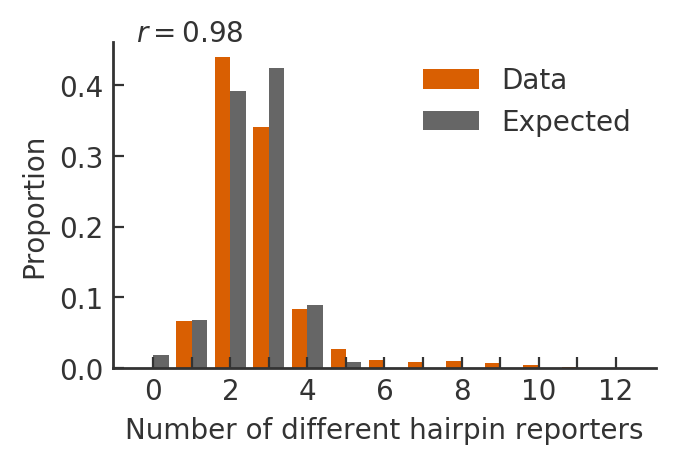

In [13]:
temp = data_f[:]
X = az.norm_array(hp_prob)
Y = Counter(temp.nb_hp.values)
Y = az.norm_array([Y[i] for i in range(len(hp_prob))])

f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.bar(2*np.arange(len(X)), Y, color=azp.colors[1], label="Data")
ax.bar(2*np.arange(len(X))+0.8, X, color=azp.colors[7], label="Expected")
ax.set_xticks(2*np.arange(len(X))+0.4)
ax.set_xticklabels([i if i%2==0 else "" for i in range(len(X))])
ax.set_ylabel("Proportion")
ax.set_xlabel("Number of different hairpin reporters")
lr = linregress(X, Y)
ax.text(-0.5, ax.get_ylim()[1], r"$r=%.2f$"%lr.rvalue)
ax.legend(loc='upper right')
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_4b.svg")), fmt='svg')
print(len(X), lr.pvalue)

### Expected and measured distribution of network sized

(17, 0.00020425049689746938)


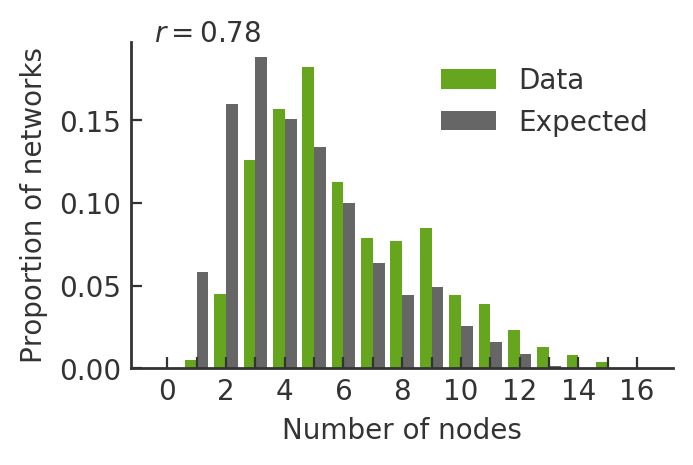

In [31]:
temp = data_f[:]
az_prob = map(lambda x: x.count("1"), az.many_fusions(E, weights=None, nb_fusion=len(temp), params=hp_prob))
c = Counter(az_prob)
X = az.norm_array([float(c[i]) if i in c.keys() else 0. for i in range(17)])
Y = Counter(temp.nb_az.values)
Y = az.norm_array([Y[i] for i in range(17)])

f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.bar(2*np.arange(len(X)), Y, color=azp.colors[4], label="Data")
ax.bar(2*np.arange(len(X))+0.8, X, color=azp.colors[7], label="Expected")
ax.set_xticks(2*np.arange(len(X))+0.4)
ax.set_xticklabels([i if i%2==0 else "" for i in range(len(X))])
ax.set_ylabel("Proportion of networks")
ax.set_xlabel("Number of nodes")
ax.legend(loc='upper right')
lr = linregress(X, Y)
ax.text(-0.5, ax.get_ylim()[1], r"$r=%.2f$"%lr.rvalue)
print(len(X), lr.pvalue)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_4c.svg")), fmt='svg')

### Correctly coded ribozyme UMI-normalized reads

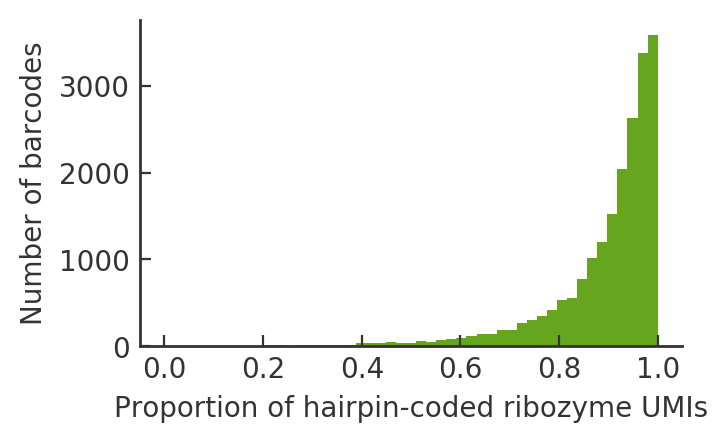

In [32]:
temp = data_f[:]
Y = temp.az_correct.values
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.hist(Y, np.linspace(0, 1, 50), color=azp.colors[4])
ax.set_xlabel("Proportion of hairpin-coded ribozyme UMIs")
ax.set_ylabel("Number of barcodes")
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_4d.svg")), fmt='svg')

### Network expected versus measured number of replicates

In [39]:
list_exp = {"jan17":"A", "apr17":"B"}
X, Y = [], []
for exp in ["jan17", "apr17"]:
    temp = data_f[data_f.spBC_letter == list_exp[exp]]
    N = 50000
    temp = temp.groupby(["az_list"]).size().reset_index(name="nb_replicates")
    weights = pd.read_csv("starting_emulsions_dist.csv")
    weights = weights.pivot(index="experiment", columns="hp", values="proportion")
    weights = list(weights[HP].loc[exp].values)
    temp_th = Counter(az.many_fusions(E, weights=weights, nb_fusion=N))
    def get_nb_replicates_th(x, temp_th):
        if x not in temp_th.keys():
            return 0.0
        else:
            return temp_th[x]/float(N)
    temp["nb_replicates_th"] = temp["az_list"].apply(lambda x: get_nb_replicates_th(x, temp_th))
    temp["nb_replicates"] = temp["nb_replicates"]/float(sum(temp["nb_replicates"].values))
    X.append(temp.nb_replicates_th.values)
    Y.append(temp.nb_replicates.values)
X = np.hstack(X)
Y = np.hstack(Y)

(2160, 0.0)


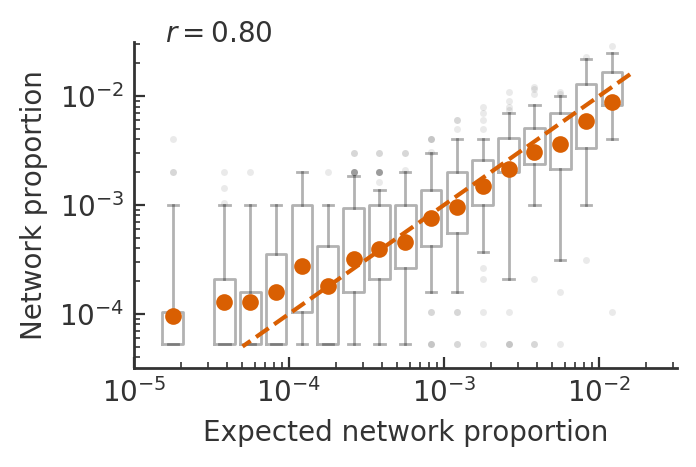

In [41]:
f = plt.figure()
ax = plt.gca()
M = X > 0
X_, Y_ = np.log10(X[M]), np.log10(Y[M])
azp.styled_boxplot(ax, X_, Y_, nbins=np.linspace(-5, 0, 31), nb_points=10, whis=[5, 95])
ax.plot([-1.8, -4.3], [-1.8, -4.3], '--', color=azp.colors[1])
mjt, mjtlab, mnt = azp.custom_log_ticks(-5, -1, base_10=True)
ax.set_xticks(mjt, minor=False)
ax.set_xticks(mnt, minor=True)
ax.set_xticklabels(mjtlab)
ax.set_yticks(mjt, minor=False)
ax.set_yticks(mnt, minor=True)
ax.set_yticklabels(mjtlab)
ax.set_xlim(-5, -1.5)
ax.set_ylim(-4.5, -1.5)
lr = linregress(X, Y)
ax.text(-4.8, ax.get_ylim()[1], r"$r=%.2f$"%lr.rvalue)
ax.set_xlabel("Expected network proportion")
ax.set_ylabel("Network proportion")
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_4e.svg")), fmt='svg')
print(len(X), lr.pvalue)

# Errorbar distribution

### Node fraction s.d.

C:\Users\smnar\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\smnar\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


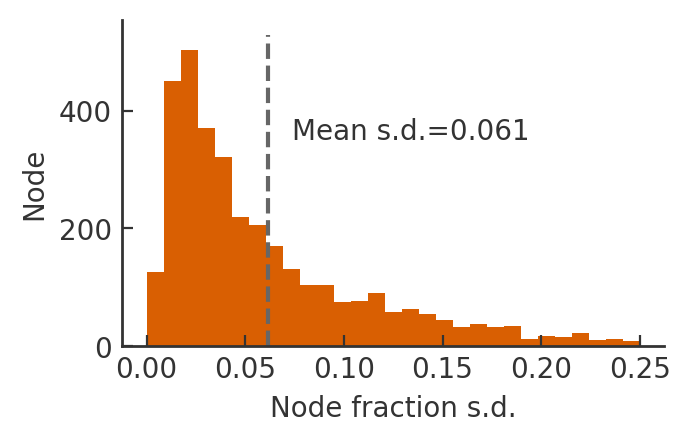

In [42]:
temp = data_f.groupby("az_list").size().reset_index(name="nb_replicate").sort_values(by="nb_replicate", ascending=False)
temp = data_f[data_f.az_list.isin(temp[temp.nb_replicate >= 5].az_list.values)]
temp["az_gd"] = temp.apply(az.genotype_distribution, axis=1)
Y = []
X = []
Z = []
for name, x in temp.groupby("az_list"):
    y = np.vstack(x.az_gd.values)
    X.append(y.mean(0))
    Y.append(y.std(0))
    Z.append(y.std(0)/y.mean(0))
    
f = plt.figure()
ax = plt.gca()
ax.hist(np.hstack(Y), np.linspace(0, 0.25, 30), color=azp.colors[1])
ax.plot([np.hstack(Y).mean()]*2, [0, ax.get_ylim()[-1]], "--", color=azp.colors[7])
ax.text(np.hstack(Y).mean()*1.2, ax.get_ylim()[-1]*0.7, "Mean s.d.=%.3f"%(np.hstack(Y).mean()), va='top')
ax.set_xlabel("Node fraction s.d.")
ax.set_ylabel("Node")
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_5d.svg")), fmt='svg')

### Number of replicates

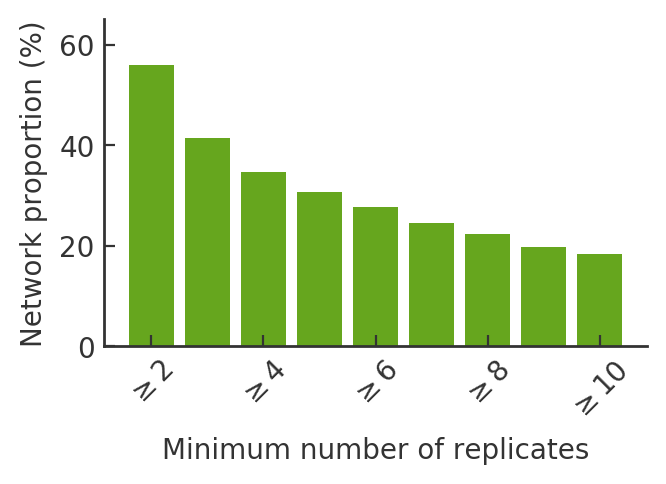

In [43]:
temp = data_f.groupby("az_list").size().reset_index(name="nb_replicates")
X = range(2, 11)
Y = [len(temp[temp.nb_replicates >= x])/float(len(temp))*100 for x in X]
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.bar(X, Y, color=azp.colors[4])
ax.set_ylabel("Network proportion (%)")
ax.set_xlabel("Minimum number of replicates")
ax.set_xticks(X[::2])
ax.set_xticklabels([r"$\geq %s$"%x for x in X[::2]], rotation=45)
ax.set_ylim(0, 65)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_5a.svg")), fmt='svg')

### Nodes fractions accross the two technical replicates

In [9]:
#Loading the data
X = az.compute_mean_per_network(data_f[data_f.spBC_letter == "B"])
Y = az.compute_mean_per_network(data_f[data_f.spBC_letter == "A"])
common = set(X.az_list.values).intersection(set(Y.az_list.values))

In [51]:
# This cell should be run only to select networks with only one replicate in one of the experiments
X_nb = {x.az_list: x.nb_replicates for _, x in data_f[data_f.spBC_letter == "B"].groupby("az_list").size().reset_index(name="nb_replicates").iterrows()}
Y_nb = {x.az_list: x.nb_replicates for _, x in data_f[data_f.spBC_letter == "A"].groupby("az_list").size().reset_index(name="nb_replicates").iterrows()}
common = [nt for nt in common if (X_nb[nt] == 1 or Y_nb[nt] == 1)]
print(len(common))

181


In [10]:
X_ = X[X.az_list.isin(common)].set_index("az_list")
X_["xdata"] = X_["az_gd"].values
Y_ = Y[Y.az_list.isin(common)].set_index("az_list")
Y_["ydata"] = Y_["az_gd"].values
temp = pd.concat([X_["xdata"], Y_["ydata"]], axis=1)
x = np.hstack(temp.xdata.values)
y = np.hstack(temp.ydata.values)

LinregressResult(slope=0.7224370208652567, intercept=0.04379718723034787, rvalue=0.8381104294476223, pvalue=0.0, stderr=0.010397940476088613)
(2047, 0.0)


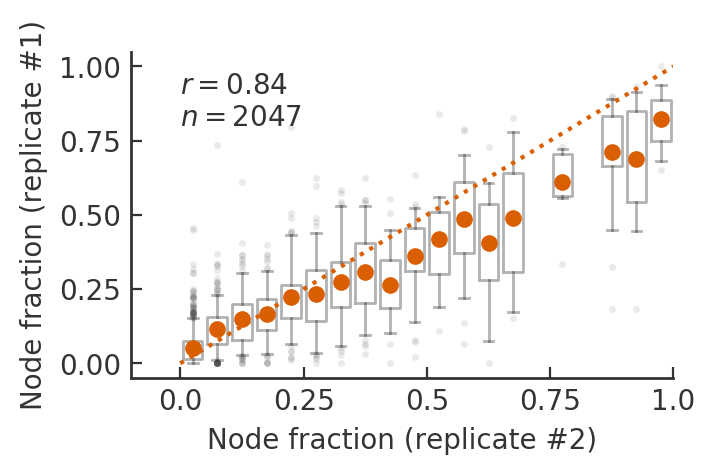

In [11]:
#Plotting

f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
azp.styled_boxplot(ax, x, y, np.linspace(0, 1, 21), whis=[5, 95], nb_points=10, ticks=True);
ax.plot([0, 1], [0, 1], ":", color=azp.colors[1])
ax.set_ylabel("Node fraction (replicate #1)")
ax.set_xlabel("Node fraction (replicate #2)")
lr = linregress(np.hstack(temp.xdata.values), np.hstack(temp.ydata.values))
print(lr)
ax.text(0, 0.8, r"$r=%.2f$"%lr.rvalue  + "\n" + r"$n=%s$"%len(x))
ax.set_xlim(-0.1, 1)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([0.00, 0.25, 0.5, 0.75, 1.00])
print(len(np.hstack(temp.xdata.values)), linregress(np.hstack(temp.xdata.values), np.hstack(temp.ydata.values)).pvalue)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_5c.svg")), fmt='svg')

### Control for quantification bias and cross-talk

In [57]:
data_ct = pd.read_csv("cross_talk_experiment_dataset.csv")
temp = data_ct[:]
temp = temp.groupby(["dpBC", "new_G"]).size().reset_index(name="nb_UMI").pivot(index="dpBC", columns="new_G", values="nb_UMI")
temp = temp.fillna(0).reset_index()
temp["az_total"] = temp.get([s for s in "ACGU"]).values.sum(1)
temp["az_max"] = temp.get([s for s in "ACGU"]).values.max(1)
for j, l in enumerate(list("ABCD")):
    temp["hp_%s"%l] = temp["hp_%s"%(2*j)] + temp["hp_%s"%(2*j+1)]
temp["hp_total"] = temp.get(["hp_%s"%s for s in "ABCD"]).values.sum(1)
temp["hp_max"] = temp.get(["hp_%s"%s for s in "ABCD"]).values.max(1)
temp = temp[(temp.az_total >= 20) & (temp.hp_total >= 10)]

In [58]:
em_prop = [['A', 'B', 'C', 'D', 'AB', 'AC', 'AD', 'BC', 'BD', 'CD', 'ABC', 'ABD', 'BCD', 'ABCD', ''], 
           [0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

def return_prop_emulsion(th):
    Y = temp.get(["hp_%s"%l for l in range(8)]).values
    A = np.vstack([list("ABCD")]*len(Y))
    M = az.norm_array(Y) > th
    M = np.array(map(lambda x: [x[2*i] and x[2*i+1] for i in range(4)], M))
    y = ["".join(A[i][M[i]]) for i in range(len(A))]
    C = Counter(y)
    y = az.norm_array([C[e] for e in em_prop[0]])
    return y

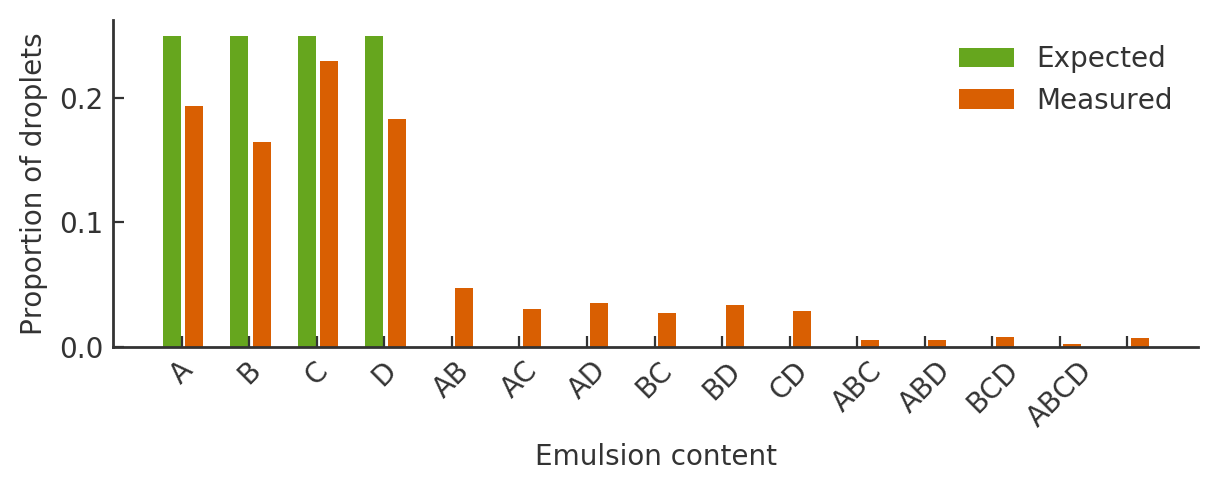

In [59]:
y = return_prop_emulsion(0.075)
f = plt.figure(figsize=(7, 3.5/golden))
ax = plt.gca()
ax.bar(3*np.arange(len(y)), em_prop[1], color=azp.colors[4], label="Expected")
ax.bar(3*np.arange(len(y))+1, y, color=azp.colors[1], label="Measured")
ax.set_xticks(3*np.arange(len(y))+0.45)
ax.set_xticklabels(em_prop[0], rotation=45)
ax.legend(loc="upper right")
ax.set_ylabel("Proportion of droplets")
ax.set_xlabel("Emulsion content")
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_5d.svg")), fmt='svg')

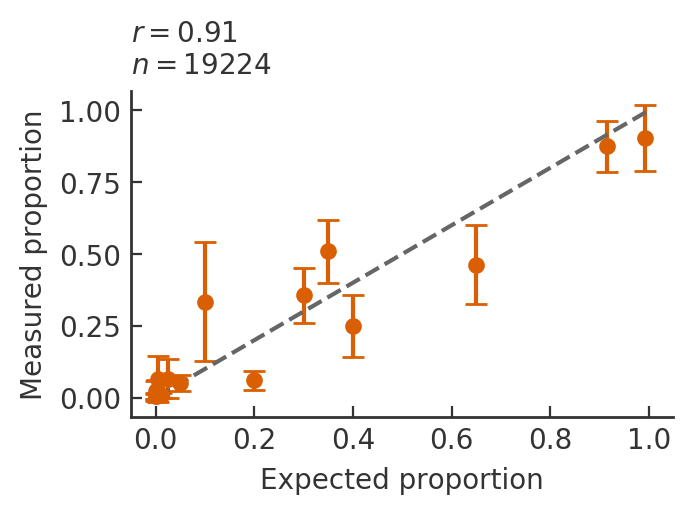

In [60]:
def which_group_percentage(x, th):
    y = az.norm_array(x.get(["hp_%s"%l for l in range(8)]).values)
    m = y > th
    m = np.array([m[2*i] and m[2*i+1] for i in range(4)])
    return ("".join(np.array(list("ABCD"))[m]))

temp["hp_group"] = temp.apply(lambda x: which_group_percentage(x, 0.075), axis=1)

exp_values = {"A": [0.3, 0.2, 0.4, 0.1], "B": [0.025, 0.01, 0.05, 0.915], "C":[0.005, 0.001, 0.0025, 0.9915], "D":[0.65, 0.0005, 0.0001, 0.3494]}
Y = az.norm_array(temp[temp.hp_group.apply(lambda x: len(x) == 1)].get(list("ACUG")).values).flatten()
Yth = np.vstack(temp[temp.hp_group.apply(lambda x: len(x) == 1)].hp_group.apply(lambda x: exp_values[x])).flatten()
Xth = sorted(np.hstack(exp_values.values()))
X = []
for x in Xth:
    X.append([Y[i] for i in range(len(Y)) if np.isclose(Yth[i], x)])
f = plt.figure()
ax = plt.gca()
ax.errorbar(Xth, map(np.mean, X), yerr=map(np.std, X), fmt=".", color=azp.colors[1], capsize=4, ms=10)
ax.plot([0, 1], [0, 1], "--" , color=azp.colors[7])
lr = linregress(Yth.flatten(), Y.flatten())
ax.set_xlabel("Expected proportion")
ax.set_ylabel("Measured proportion")
ax.set_title(r"$r=%.2f$"%lr.rvalue+"\n"+r"$n=%s$"%len(Y), loc='left', fontsize=10)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_5e.svg")), fmt='svg')

LinregressResult(slope=0.5241747242247894, intercept=-0.31697776379755405, rvalue=0.7921022266168005, pvalue=0.0, stderr=0.0031512464415363287)
Wall time: 5.04 s


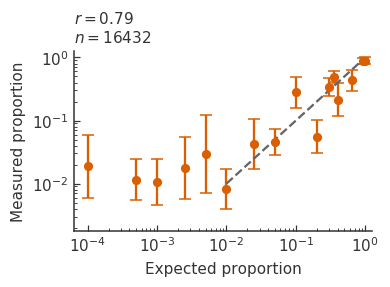

In [14]:
%%time
exp_values = {"A": [0.3, 0.2, 0.4, 0.1], "B": [0.025, 0.01, 0.05, 0.915], "C":[0.005, 0.001, 0.0025, 0.9915], "D":[0.65, 0.0005, 0.0001, 0.3494]}
Y = az.norm_array(temp[temp.hp_group.apply(lambda x: len(x) == 1)].get(list("ACUG")).values).flatten()
Yth = np.vstack(temp[temp.hp_group.apply(lambda x: len(x) == 1)].hp_group.apply(lambda x: exp_values[x])).flatten()
M = np.isclose(Y, 0)
Y, Yth = np.log10(Y[~M]), np.log10(Yth[~M])
Xth = sorted(np.log10(np.hstack(exp_values.values())))
X = []
for x in Xth:
    X.append([Y[i] for i in range(len(Y)) if np.isclose(Yth[i], x)])
f = plt.figure()
ax = plt.gca()
ax.errorbar(Xth, map(np.mean, X), yerr=map(np.std, X), fmt=".", color=azp.colors[1], capsize=4, ms=10)
ax.plot([-2, 0], [-2, 0], "--" , color=azp.colors[7])
print(linregress(Yth.flatten(), Y.flatten()))
mjt, mjtlab, mnt = azp.custom_log_ticks(-4, 0, base_10=True)
ax.set_xticks(mjt, minor=False)
ax.set_xticks(mnt, minor=True)
ax.set_xticklabels(mjtlab)
ax.set_xlim(-4.2, 0.1)
ax.set_yticks(mjt, minor=False)
ax.set_yticks(mnt, minor=True)
ax.set_yticklabels(mjtlab)
ax.set_ylim(-2.75, 0.1)
ax.set_xlabel("Expected proportion")
ax.set_ylabel("Measured proportion")
lr = linregress(Yth.flatten(), Y.flatten())
ax.set_title(r"$r=%.2f$"%lr.rvalue+"\n"+r"$n=%s$"%len(Y), loc='left', fontsize=10)

C:\Users\smnar\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


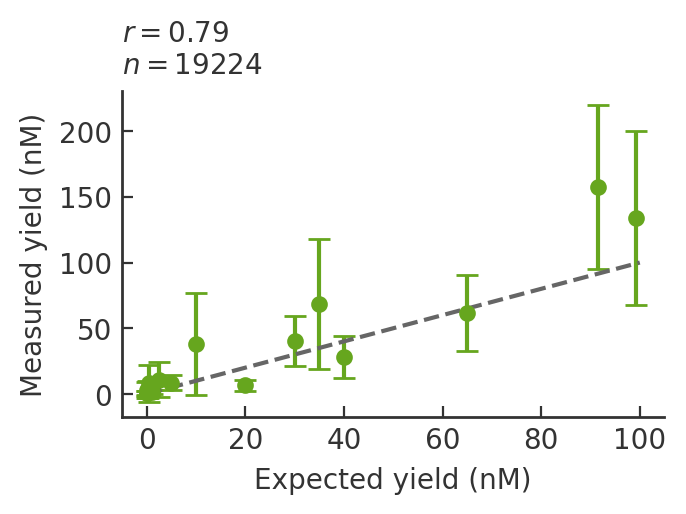

In [64]:
def scaling_factor(x):
    scaling_factor = 10/x.get("hp_%s"%x.hp_group)
    return scaling_factor
exp_values = {"A": list(np.array([0.3, 0.2, 0.4, 0.1])*100), 
              "B": list(np.array([0.025, 0.01, 0.05, 0.915])*100), 
              "C": list(np.array([0.005, 0.001, 0.0025, 0.9915])*100), 
              "D": list(np.array([0.65, 0.0005, 0.0001, 0.3494])*100)}
tmp = temp[temp.hp_group.apply(lambda x: len(x) == 1)]
tmp["sf"] = tmp.apply(scaling_factor, axis=1)
Y = tmp.get(list("ACUG")).values
sf = np.repeat(tmp["sf"].to_numpy(), 4).reshape((len(tmp), 4))
Y = (Y*sf).flatten()
Yth = np.vstack(tmp.hp_group.apply(lambda x: exp_values[x])).flatten()
Xth = sorted(np.hstack(exp_values.values()))
X = []
for x in Xth:
    X.append([Y[i] for i in range(len(Y)) if np.isclose(Yth[i], x)])

f = plt.figure()
ax = plt.gca()
ax.errorbar(Xth, map(np.mean, X), yerr=map(np.std, X), fmt=".", color=azp.colors[4], capsize=4, ms=10)
ax.plot([0, 100], [0, 100], "--" , color=azp.colors[7])
lr = linregress(Yth.flatten(), Y.flatten())
ax.set_xlabel("Expected yield (nM)")
ax.set_ylabel("Measured yield (nM)")
ax.set_title(r"$r=%.2f$"%lr.rvalue+"\n"+r"$n=%s$"%len(Y), loc='left', fontsize=10)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_5f.svg")), fmt='svg')

In [132]:
def scaling_factor(x):
    scaling_factor = 10/x.get("hp_%s"%x.hp_group)
    return scaling_factor
exp_values = {"A": list(np.array([0.3, 0.2, 0.4, 0.1])*100), 
              "B": list(np.array([0.025, 0.01, 0.05, 0.915])*100), 
              "C": list(np.array([0.005, 0.001, 0.0025, 0.9915])*100), 
              "D": list(np.array([0.65, 0.0005, 0.0001, 0.3494])*100)}
tmp = temp[temp.hp_group.apply(lambda x: len(x) == 1)]
tmp["sf"] = tmp.apply(scaling_factor, axis=1)
Y = tmp.get(list("ACUG")).values
sf = np.repeat(tmp["sf"].to_numpy(), 4).reshape((len(tmp), 4))
Y = (Y*sf).flatten()
Yth = np.vstack(tmp.hp_group.apply(lambda x: exp_values[x])).flatten()
M = np.isclose(Y, 0)
Y, Yth = np.log10(Y[~M]), np.log10(Yth[~M])
Xth = sorted(np.log10(np.hstack(exp_values.values())))
X = []
for x in Xth:
    X.append([Y[i] for i in range(len(Y)) if np.isclose(Yth[i], x)])

f = plt.figure()
ax = plt.gca()
ax.errorbar(Xth, map(np.mean, X), yerr=map(np.std, X), fmt=".", color=azp.colors[1], capsize=4, ms=10)
ax.plot([-0.75, 2], [-0.75, 2], "--" , color=azp.colors[7])
mjt, mjtlab, mnt = azp.custom_log_ticks(-2, 3, base_10=True)
ax.set_xticks(mjt, minor=False)
ax.set_xticks(mnt, minor=True)
ax.set_xticklabels(mjtlab)
ax.set_xlim(-2.2, 2.5)
ax.set_yticks(mjt, minor=False)
ax.set_yticks(mnt, minor=True)
ax.set_yticklabels(mjtlab)
ax.set_ylim(-0.75, 2.5)
ax.set_xlabel("Expected concentration (nM)")
ax.set_ylabel("Measured concentration (nM)")
lr = linregress(Yth.flatten(), Y.flatten())
ax.set_title(r"$r=%.2f$"%lr.rvalue+"\n"+r"$n=%s$"%len(Y), loc='left', fontsize=10)
# f.savefig(os.getcwd() + "/extended_data_figures/edf_5g.svg", fmt='svg')

# Figure 1d for all sizes

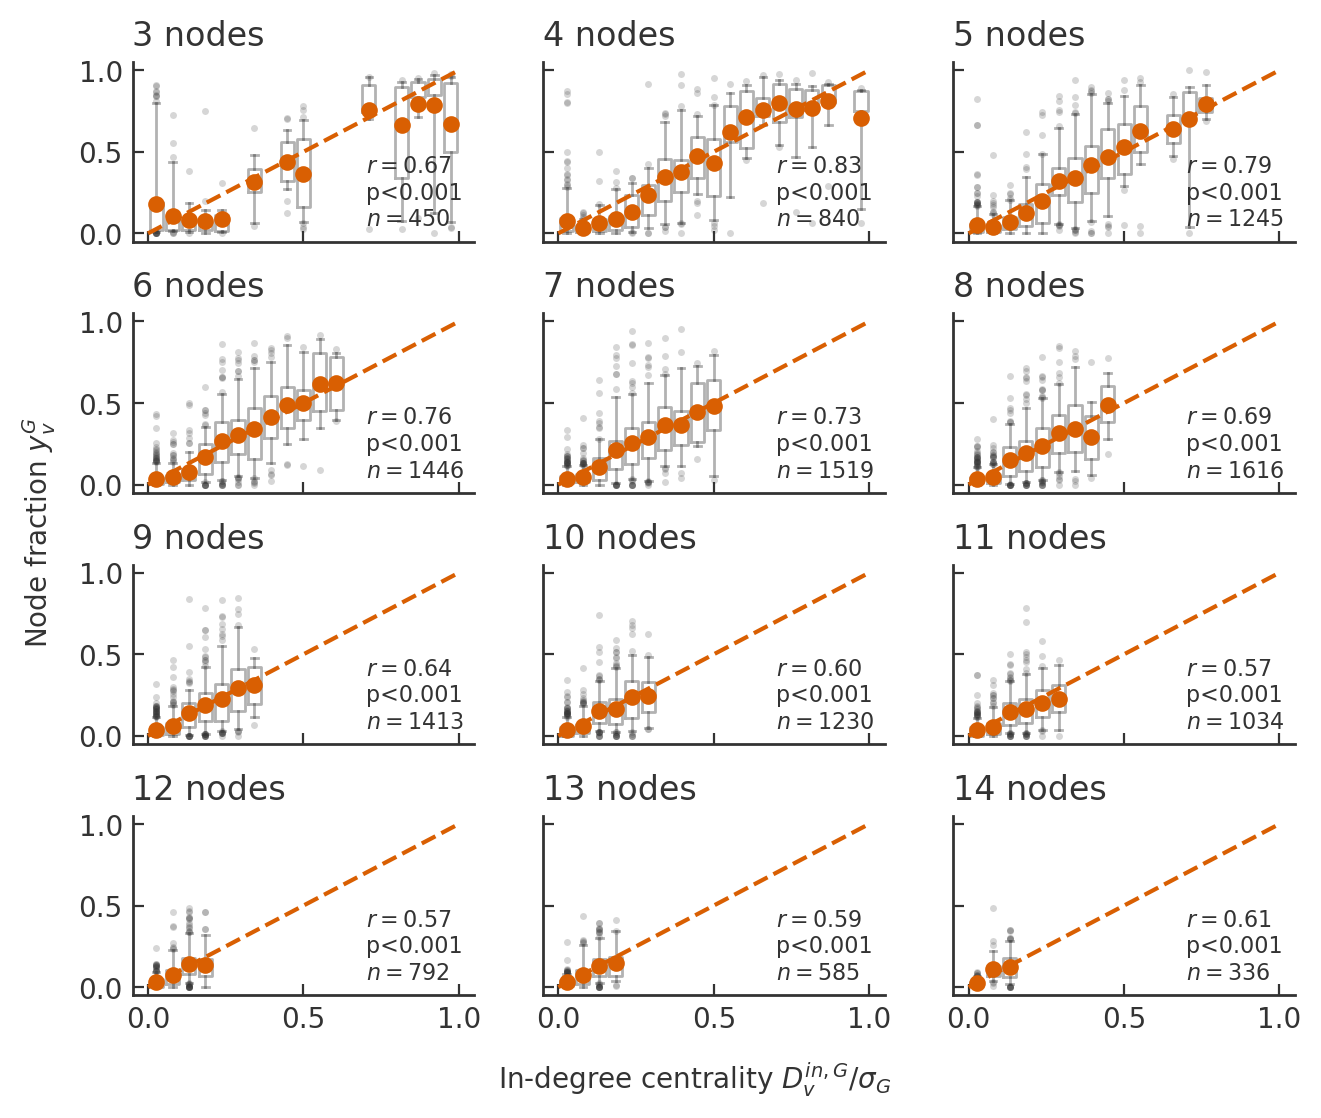

In [145]:
f, axa = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(7.5, 2.5/golden*4))
for size in range(3, 15):
    ax = axa[(size-3)/3, (size-3)%3]
    temp = data_[data_.nb_az == size]
    X = np.hstack(temp.az_list.apply(lambda x: azm.az_kinetic_model(x, 60, ka_rates, kb_rates)).values)
    Y = np.hstack(temp.az_gd.values)
    bxp = azp.styled_boxplot(ax, X, Y, nbins=np.linspace(0, 1, 20), nb_points=10, showfliers=True, alphafliers=0.2, alpha=0.3, whis=[5, 95]);
    ax.plot([0, 1], [0, 1], "--", color=azp.colors[1])
    h = 0.05
    ymin, ymax = 0, 1
    xmin, xmax = 0, 1
    ax.set_xlim(xmin-h, xmax+h)
    ax.set_ylim(ymin-h, ymax+h)
    m = mpl.ticker.MaxNLocator(nbins=2)
    ax.set_xticks(m.tick_values(xmin, xmax))
    ax.set_xticklabels(m.tick_values(xmin, xmax))
    ax.set_yticks(m.tick_values(ymin, ymax))
    ax.set_yticklabels(m.tick_values(ymin, ymax))
    lr = stats.linregress(X, Y)
    if lr.pvalue < 0.001:
        pvalue = "p<0.001"
    else:
        pvalue = r"$p=%.2g$"%lr.pvalue
    ax.text(0.7, 0.25, r"$r=%.2f$"%lr.rvalue + "\n" + pvalue + "\n" + r"$n=%s$"%len(X), va='center', fontsize=8)
    ax.set_title("%s nodes"%size, loc='left')
f.text(0.5, 0.05, "In-degree centrality " + r"$D^{in,G}_{v}/\sigma_G$", ha='center')
f.text(0.05, 0.5, "Node fraction " + r"$y^G_v$", rotation=90, va='center')
f.subplots_adjust(hspace=0.4)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_6d.svg")), fmt='svg')

# Distribution of number of UMI per droplets

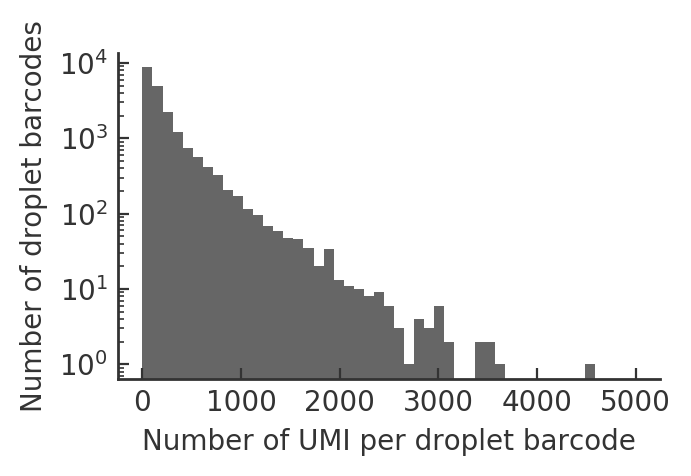

In [146]:
f = plt.figure(figsize=(3.5, 3.5/golden))
ax = plt.gca()
ax.hist(data_f.az_total, np.linspace(0, 5000, 50), log=1, color=azp.colors[7])
ax.set_xlabel("Number of UMI per droplet barcode")
ax.set_ylabel("Number of droplet barcodes")
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_3f.svg")), fmt='svg')

### Other values for m & n parameters

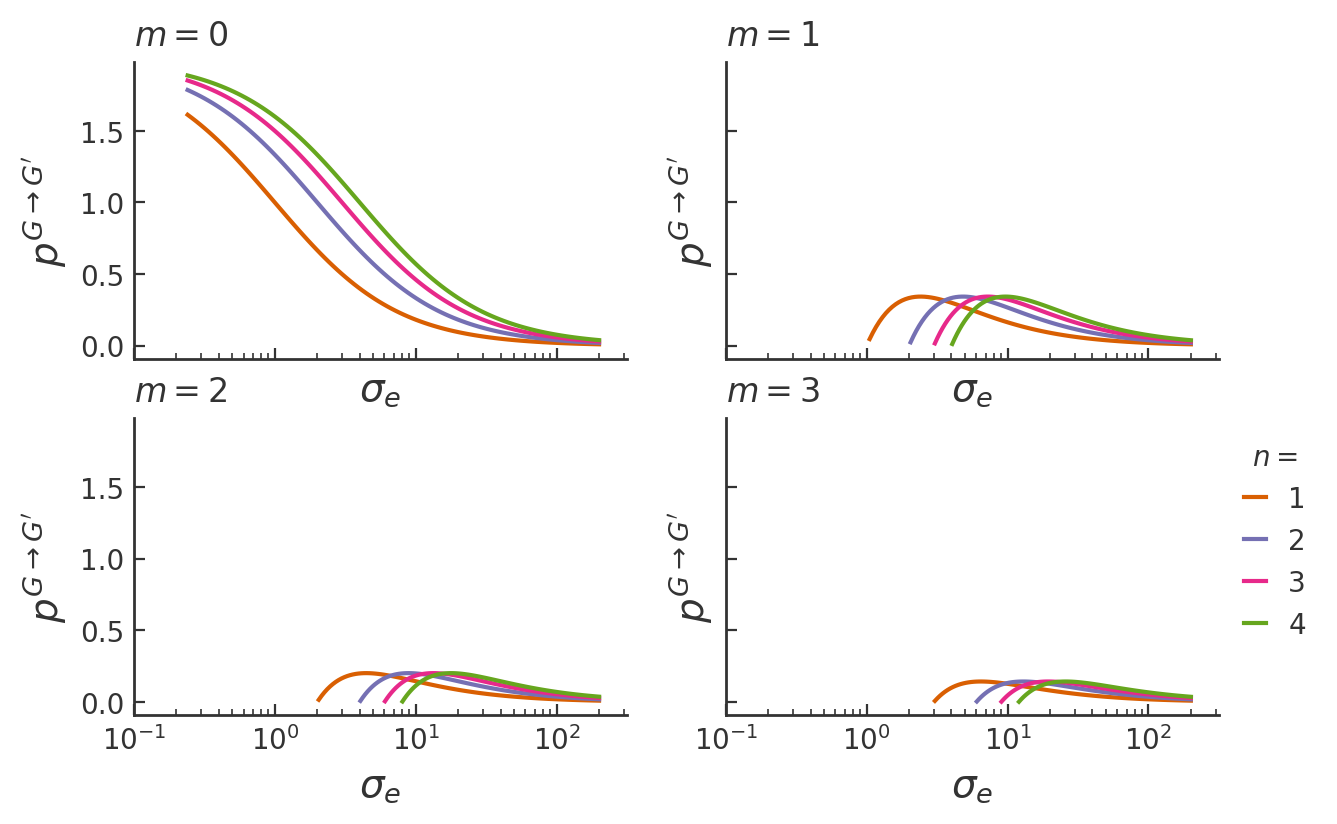

In [167]:
def plot_aux_data(ax, m, n, color, xmax=200, fmt="o", ms=7, mew=1.5, lw=1.5, cs=3, log=1):
    temp_ = temp[(np.isclose(temp.m, m)) & (np.isclose(temp.n, n))]
    #ax.plot(np.log10(temp_.sigma_e), temp_.abs_p_v, '.', color=color, alpha=0.3)
    nbins = 20
    xbins = np.logspace(np.log10(0.08/0.42), np.log10(xmax), nbins+1)
    ix = np.digitize(temp_.sigma_e, xbins) - 1
    y_ = np.array([temp_.abs_p_v[ix == i].mean() for i in range(nbins)])
    z_ = np.array([temp_.abs_p_v[ix == i].std() for i in range(nbins)])
    w_ = np.array([len(temp_.abs_p_v[ix == i]) for i in range(nbins)])
    x_ = np.array([np.log10((xbins[i] + xbins[i+1])*0.5) for i in range(nbins)])
    M = np.invert(np.isnan(y_)) * (w_ >= 3)
    if log:
        ax.errorbar(x_[M], np.log10(y_[M]), yerr=np.log10(z_[M]), fmt=fmt, color=color, ms=ms, markerfacecolor="w", markeredgewidth=mew, capsize=cs, linewidth=lw)
    else:
        ax.errorbar(x_[M], y_[M], yerr=z_[M], fmt=fmt, color=color, ms=ms, markerfacecolor="w", markeredgewidth=mew, capsize=cs, linewidth=lw)        
    
def plot_aux_th(ax, m, n, color, xmax=200, lw=1.5, label="", log=1):
    xmin = max(n*m, 0.08/0.42)+0.05
    x = np.logspace(np.log10(xmin), np.log10(xmax), 100)
    y = 2*n*(1-(m*n)/x)/(x+n)
    if log:
        ax.plot(np.log10(x), np.log10(y), color=color, lw=lw, label=label)
    else:
        ax.plot(np.log10(x), y, color=color, lw=lw, label=label)
    
def tick_aux(ax):
    mjt, mjtlab, mnt = azp.custom_log_ticks(-1, 3, base_10=True)
    ax.set_xticks(mjt, minor=False)
    ax.set_xticks(mnt, minor=True)
    ax.set_xticklabels(mjtlab)
    ax.set_xlim(-1, 2.5)
    ax.set_ylabel(r"$p^{G \rightarrow G'}$", fontsize=14)
    ax.set_xlabel(r"$\sigma_e$", fontsize=14)

x, y = [2, 2], [1, 1.2]
f, axa = plt.subplots(2, 2, figsize=(7, 3.5/golden*2), sharex=True, sharey=True)
log = 0
for m in range(4):
    ax = axa[m/2, m%2]
    ax.set_title(r"$m=%s$"%m, loc="left")
    for n in range(1, 5):
        plot_aux_th(ax, m, n, azp.colors[n], log=log, label=str(n))
    tick_aux(ax)
axa[1, 1].legend(bbox_to_anchor=(1, 1), title=r"$n=$", handlelength=0.8)
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_8.svg")), fmt='svg')

# Order for doublets

In [67]:
def compare_triplets_order(name_rates):
    size = 5
    #temp = data_[data_.nb_az == size]
    temp = data_[:]

    res = []
    epsilon = 0.00
    random_rates = np.random.rand(16)
    #random_rates = np.arange(16)
    N = 1
    for name, row in temp.iterrows():
        if name_rates == "data":
            y = row["az_gd"]
        elif name_rates == "kb":
            y = [azm.degree(g, row["az_list"], 1, 'in', rates) for g in az.transform(row["az_list"])]
        elif name_rates == "random":
            y = az.norm_array([random_rates[G.index(g)] for g in az.transform(row["az_list"])])
        elif name_rates == "ka":
            y = azm.asymptotic_solution(row["az_list"], ka_rates)[0]
        n = len(y)
        x = az.transform(row["az_list"])
        d = {x[i]:y[i] for i in range(n)}
        for c in list(combinations(x, 2)):
            o = np.array([d[c[i]] for i in range(2)])
            if o[0] == o[1]:
                res.append([az.transform(list(c)), "="])
            if o[0] != o[1]:
                res.append([az.transform(list(c)), "<".join(np.array(c)[o.argsort()])])
    res = pd.DataFrame(res, columns=["doublets", "order"])

    Y = []
    for name, group in res.groupby("doublets").filter(lambda x: len(x) >= 0).groupby("doublets"):
        y = group.groupby("order").size().values
        y = y.max()/float(y.sum())
        Y.append(y)
    print(len(Y))
    f = plt.figure()
    ax = plt.gca()
    ax.hist(Y, np.linspace(0, 1, 20), color=azp.colors[1])
    ax.set_xlabel("Proportion of top triplet order")
    ax.set_ylabel("Triplet count")
    
    return res, np.array(Y)

120
              doublets  order
100   0000000010000010  UA<GU
1663  0000000000110000  UU<UG
3949  0000000010000010  UA<GU
0.633333333333


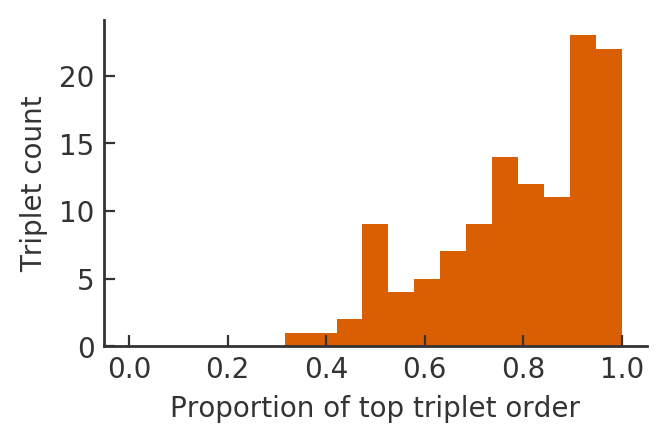

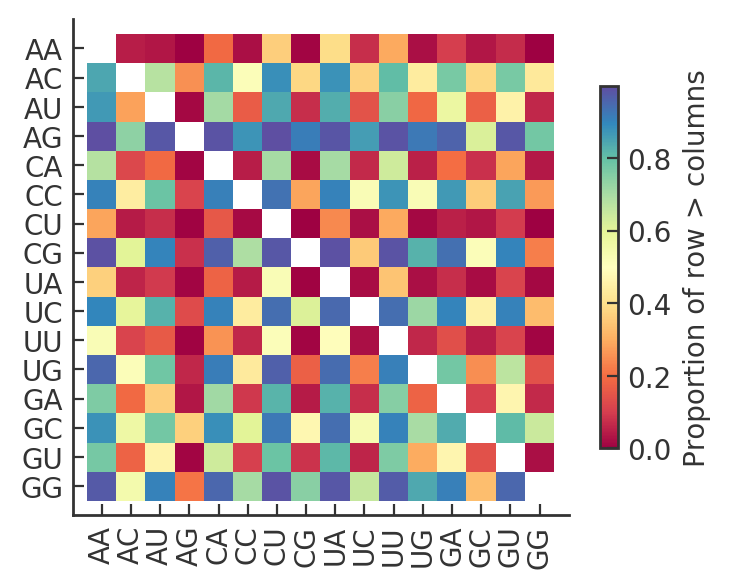

In [71]:
df, Y = compare_triplets_order("data")
print(df.sample(3))
print(float(sum(Y < 0.9))/len(Y))

M = np.zeros((16, 16))
for i in range(16):
    for j in range(16):
        if i == j:
            M[i, j] = np.nan
        else:
            g = az.G[i]
            h = az.G[j]
            c = Counter(df[df.doublets == az.transform([g, h])].order.values)
            v = float(c[h+"<"+g])/(c[g+"<"+h]+c[h+"<"+g]+c["="])
            M[i, j] = v
f = plt.figure(figsize=(4, 4))
ax = plt.gca()
cmap = mpl.cm.get_cmap("Spectral")
cmap.set_bad('w')
im = ax.imshow(M, cmap=cmap)
ax.set_xticks(range(16))
ax.set_xlim(-1, 16)
ax.set_ylim(16, -1)
ax.set_yticks(range(16))
ax.set_xticklabels(az.G, rotation=90)
ax.set_yticklabels(az.G, rotation=0)
cbar = f.colorbar(im, shrink=0.6, ticks=[0., 0.2, 0.4, 0.6, 0.8, 1.])
cbar.set_label("Proportion of row > columns")
f.savefig(str(cwd.joinpath("figures/supplementary_figures/SI_6a.svg")), fmt='svg')

# Supplementary Table 2

In [14]:
nb_replicates = dict(data_f.groupby("az_list").size())
data_["nb_replicates"] = data_.az_list.apply(lambda x: nb_replicates[x])

In [34]:
df = []
for size in range(2, 16):
    tmp = data_[(data_.nb_az == size) & (data_.nb_replicates >= 10)]
    sorted_nt = tmp.sort_values(by="yield").az_list.to_numpy()
    min_nt = sorted_nt[0]
    max_nt = sorted_nt[-1]
    res = [size, 
           len(tmp), 
           round(tmp["yield"].mean(), 1), 
           round(tmp["yield"].std(), 1), 
           round(tmp["yield"].min(), 1), 
           round(tmp["yield"].max(), 1),
           round(tmp["yield"].max()/tmp["yield"].min(), 1),
           "%.2g"%(stats.ttest_ind(data_f[data_f.az_list == min_nt]["yield"].to_numpy(), 
                           data_f[data_f.az_list == max_nt]["yield"].to_numpy()).pvalue/2)]
    df.append(res)
df = pd.DataFrame(df, columns=["nt_size", "nb_nt", "mean_yield", "sd_yield", "min_yield", "max_yield", "fold_diff_yield", "pvalue"])
df.to_excel("SI_Table2.xlsx")